$\textbf{Vergleich von $k$-means und Spectralem Clustering bei nicht konvexen Daten} \\$
In diesem Notebook wollen wir zunächst an einem Beispiel die Problematik von $k$-means, nur konvexe Cluster zu finden, erläutern.
Dazu erzeugen wir einen Datensatz der aus einem großen und einem kleinen Kreis besteht.
Wir importieren zu Beginn alle notwendigen Bibliotheken und bereits aus anderen Notebooks bekannten Funktionen

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
import networkx as nx


#Importiere Funktionen aus anderen Notebooks
#Erklärung der Funktion folgt später
#Mittelwertmethode:
def Mittelwertmethode (Daten, n):
    #Berechne kNN-Matrix mit Distanzen mit k wie oben angegeben
    k = int(np.ceil(np.log(n) +1)) #aufgerundetes k damit k integer
    
    #Adjazenzmatrix für knn-Graphen
    A_1_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance').toarray()
    
    #Mittelwert aller Einträge != 0 für jede Zeile, dies Eentspricht dem mittleren Abstand pro Knoten 
    #zu seinen k nächsten Nachbarn
    zeilen_mittelwert = np.sum(A_1_knn_dis, axis=1) /k 
    
    #mittelwert dieser Abstände
    mittelwert = np.mean(zeilen_mittelwert)
    
    return(mittelwert)


def SC_kNN_Graph (Daten, SC, k, sigma):
    #Anzahl der Datenpunkte
    n = Daten.shape[0]
    
    A_knn_dis = kneighbors_graph(Daten, n_neighbors=k, mode= 'distance', include_self = False).toarray()  #Adjazenzmatrix mit Gewichten d_{ij}
    A_knn_con = kneighbors_graph(Daten, n_neighbors=k, mode= 'connectivity', include_self = False).toarray() #ungewichtete Adjazenzmatrix

    #Wir benutzen die Gaußsche Ähnlichkeitsfkn., um Distanzen d_{ij} in Ähnlichkeiten umzuwandeln
    #Wir müssen aufpassen, dass wenn A_2_knn_{ij} = 0, dann  S_2_knn_{ij}= 0  ebenfalls, deshalb wenden wir erst 
    #Gaußkern eintragsweise an und multiplizieren dann erneut eintragsweise mit A_2_knn_con, damit Einträge, 
    #die null waren nun wieder null sind und nicht eins.
    S_knn = A_knn_con * np.exp(- A_knn_dis ** 2 / (2. * sigma ** 2)) #Ähnlichkeitsmatrix

    #Symmetrisieren der Ähnlichkeitsmatrix 
    for i in range(n):
        for j in range(i):
            max = np.maximum(S_knn[i,j], S_knn[j,i])
            S_knn[i,j] = max
            S_knn[j,i] = max
    
    #Erstelle Graphen
    G_knn = nx.from_numpy_array(S_knn , create_using=nx.Graph)
    
    #Spectral Clustering mittels Ähnlichkeitsmatrix
    SC.fit(S_knn)
    
    #label
    labels = SC.labels_
    
    #Gebe Graphen und label zurücl
    return(G_knn, labels)



Nun erzeugen wir den Datensatz bestehend aus 500 Punkten $X_1, \dots , X_{500}$ und plotten diesen anschließend. Wir benutzen dazu die Funktion 'make_cicles' von sklearn. 
Diese erzeugt zunächst $Y_1, \dots , Y_{250}$ und $Z_1, \dots , Z_{250}$  mit 
\begin{align} Y_i = \begin{pmatrix} \cos((i-1) \frac{2\pi}{249}) \\ \sin((i-1) \frac{2\pi}{249}) \end{pmatrix} \end{align} und
\begin{align} Z_i = 0.8\begin{pmatrix} \cos((i-1) \frac{2\pi}{249}) \\ \sin((i-1) \frac{2\pi}{249}) \end{pmatrix}, \end{align}
also jeweils 250 Punkte, die auf einem Kreis mit Radius 1 und 250 Punkte, die auf einem Kreis mit Radius 0.8 liegen.
Danach definiert die Funktion $X_1, \dots X_{250} = Y_1, \dots , Y_{250}$ und $X_{251}, \dots X_{500} = Z_1, \dots , Z_{250}$ und addiert für jedes $X_i$ in beiden Dimensionen eine normalverteilte Zufallsvariable mit Mittelwert $\mu = 0$ und Varianz $\sigma^2$ auf. Den Wert für $\sigma$ legen wir dabei mit dem Parameter 'noise' fest.



Text(0.5, 1.0, 'Kreise: Originale Gruppenzugehörigkeit')

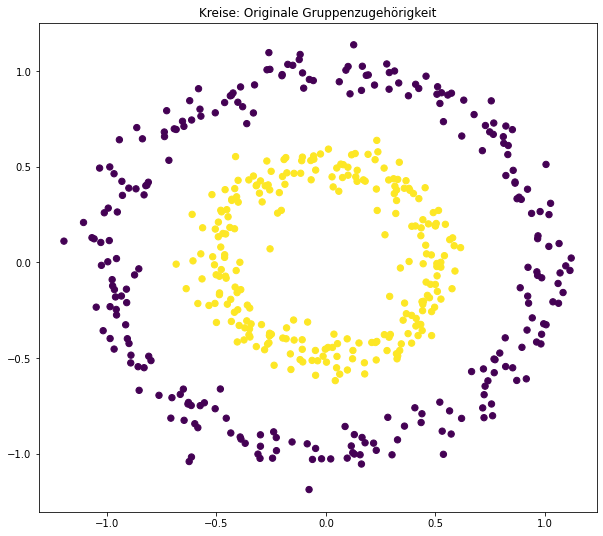

In [3]:
random_state = 1 #Wir wählen einen random_state, damit Ergebnisse reproduzierbar sind
n = 500 #Anahl der Datenpunkte

Kreise, zugekörigkeit = datasets.make_circles(n_samples=n, factor=0.5, noise=0.07, shuffle= False, 
                                              random_state= random_state) 


plt.figure(figsize= (10,9))
#Plotte Datensatz mit tatsächlicher Gruppenzugehörigkeit
plt.scatter(Kreise[:, 0], Kreise[:, 1], s= 40, c= zugekörigkeit , cmap = 'viridis')
plt.title("Kreise: Originale Gruppenzugehörigkeit")

Ziel beim $k$-means-Clustering ist es, eine Partition $S_1, S_2 $ mit Zentren $\mu_1, \mu_2 $ zu finden, die 
\begin{align}
    \sum_{x_i \in S_{1}} \| x_{i} - \mu_{l}\|^2 + \sum_{x_i \in S_{2}} \| x_{i} - \mu_{l}\|^2
    \label{eq:minimierung_kmeans1}
\end{align}
minimiert. Dazu wählen wir in jedem Schritt Zentren $\mu_1,\mu_2$, ordnet jedem Punkt, dem Cluster zu, dessen Mittelpunkt am nächsten ist und aktualiseren die Mittelpunkte als Durchschnitt der Datenpunkte pro Cluster.
Bedingt durch die Minimierung der Abstände zu den Zentren findet $k$-means dabei nur konvexe Cluster. In folgendem Plot sehen wir, dass $k$-means die Kreise jeweils, wie einen Kuchen in der Mitte durchschneidet. Für dieses Beispiel ist er also ungeeignet:

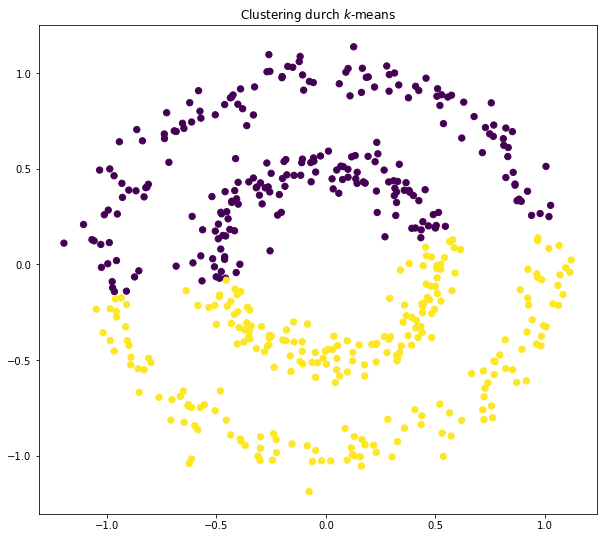

In [7]:
kmeans = KMeans(n_clusters=2).fit_predict(Kreise) #Label für jeden Datenpunkt

plt.figure(figsize= (10,9))
plt.scatter(Kreise[:, 0], Kreise[:, 1], s= 40, c= kmeans , cmap = 'viridis')
plt.title("Clustering durch $k$-means")
plt.show()

Wir werden nun sehen, dass wir die Daten mittels Spectralem Clustering (SC) korrekt zuordnen können. Wir benutzen für das SC den $k$NN-Graphen mit Parametern $k$ und $\sigma$, die wir durch die Mittelwertmethode wählen.

k =  8 
 sigma =  0.08219968964138358


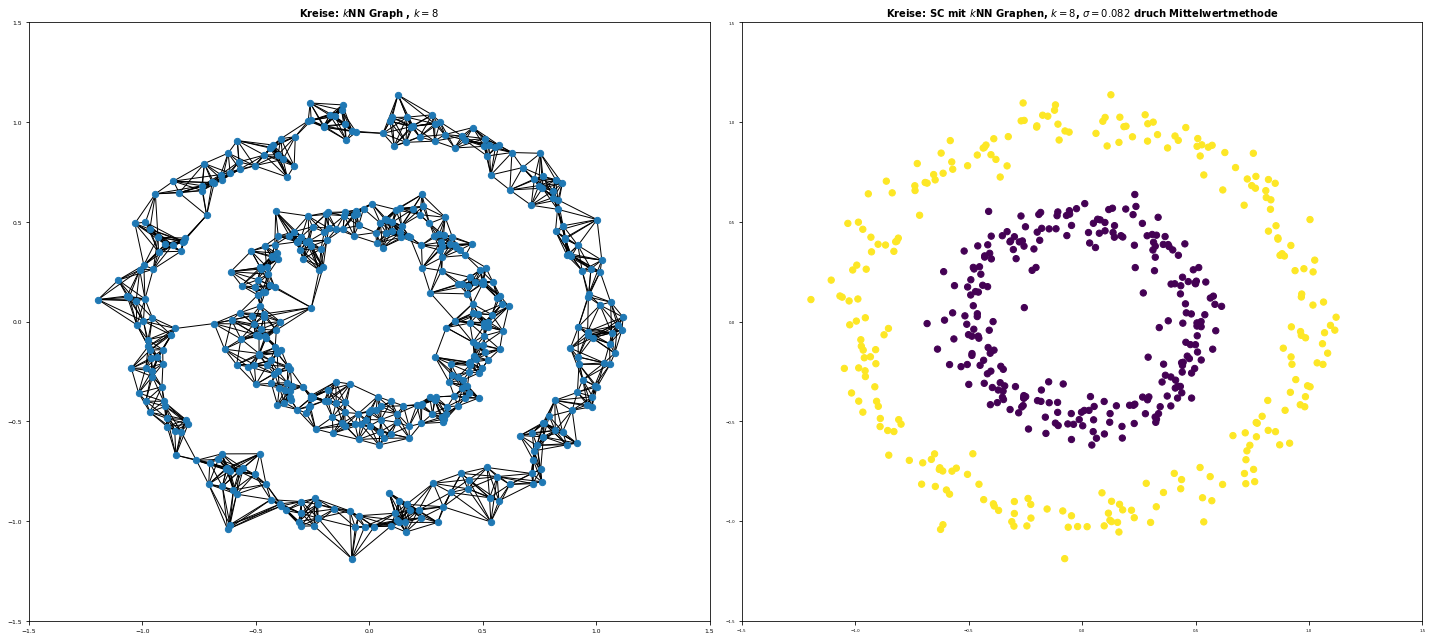

In [9]:
k = int(np.ceil(np.log(n) +1))
sigma = Mittelwertmethode(Kreise, n)  

print('k = ', k , '\n', 'sigma = ', sigma)


SC = SpectralClustering(n_clusters=2, affinity='precomputed' )


#Wir verwenden hier als Ähnlichkeitsgraphen den kNN-Graphen mit k und sigma durch die Mittelwertmethode
G_knn, SC_labels = SC_kNN_Graph(Kreise, SC, k = k, sigma = sigma)


#Zum Plotten benötigen wir für jeden Knoten eine Position
pos= {}
for i in range (n):
    pos[i] = (Kreise[i, 0], Kreise[i, 1])
    


fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(20,9))

ax[0].set_title('Kreise: $k$NN Graph , $k = 8$', fontsize=10, fontweight='demi')
nx.draw(G_knn, pos = pos, width = 1, node_size = 40,ax=ax[0] )
ax[0].set_axis_on()
ax[0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 6)
ax[0].set_xlim([-1.5, 1.5])
ax[0].set_ylim([-1.5, 1.5])


#Plotte Datensatz mit SC
ax[1].set_title('Kreise: SC mit $k$NN Graphen, $k = 8$, $\sigma = 0.082$ druch Mittelwertmethode', fontsize=10, fontweight='demi')
ax[1].scatter(Kreise[:, 0], Kreise[:, 1], s= 40, c= SC_labels , cmap = 'viridis')
ax[1].set_axis_on()
ax[1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 4)
ax[1].set_xlim([-1.5, 1.5])
ax[1].set_ylim([-1.5, 1.5])

fig.tight_layout()


plt.show()

Beim Clustering werden Datenpunkte in $k$ Cluster gruppiert, indem jedem Punkt eine Zahl (label) $\in \{0,1, \dots, k-1\}$ zugeordnet wird, die angibt in welchem Cluster er sich befindet. Diese label werden in einem Array gespeichert. Im Folgenden berechnen wir die Anzahl der Punkte, die falsch zugeordnet wurden. Da wir nicht wissen, welches Cluster der Algorithmus mit welcher Zahl identifiziert, betrachten wir auch in den invertierten Fall und nehmen jene Labelung, die mit der Originallabelung am besten übereinstimmt. 

In [10]:
#Unser Algorithmus ordnet jedem Punkt entweder die 0 oder die 1 zu. Dabei kann er den innerem Kreis entweder die Zahl 1 
#oder 0 zurodnen. Aus diesem Grund betrachten wir auch den Fall, unsere durch den Algrithmus entstandene Zuordnung zu 
#invertieren, das heißt wir ordnen allen Punkten mit label 0 die 1 und mit label 1 die 0 zu.

SC_labels_inv = abs(SC_labels -1 ) #invertierte labels

#Falsch zugeordneten Punkte 
anz_falsch = min( sum( abs(zugekörigkeit- SC_labels)), sum( abs(zugekörigkeit- SC_labels_inv))) 

print('Wir konnten ', n- anz_falsch, 'von ', n, 'Punkten richtig clustern.')




Wir konnten  500 von  500 Punkten richtig clustern.


Nun plotten wir zur besseren Darstellung alles in einem großen Plot, um diesen in der Arbeit zu verwenden. Die hier erzeugte Abbildung entspricht Abbildung 1 in der Arbeit.

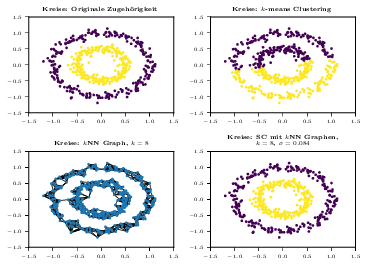

In [11]:
#Zum plotten nehmen wir ebenfalls die Label, die mit der originalen Zugehörigkeit am besten übereinstimmen
if sum( abs(zugekörigkeit- SC_labels)) > sum( abs(zugekörigkeit- SC_labels_inv)):
    SC_labels = SC_labels_inv
    

import matplotlib    
matplotlib.use("pgf")
matplotlib.rcParams.update({
   "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})    
    
fig, ax = plt.subplots(nrows=2, ncols=2,figsize=(20,16))

ax[0,0].set_title('Kreise: Originale Zugehörigkeit ', fontsize=6, fontweight='demi')
ax[0,0].scatter(Kreise[:, 0], Kreise[:, 1], s= 2, c= zugekörigkeit , cmap = 'viridis')
ax[0,0].set_axis_on()
ax[0,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 4)
ax[0,0].set_xlim([-1.5, 1.5])
ax[0,0].set_ylim([-1.5, 1.5])


ax[0,1].set_title('Kreise: $k$-means Clustering  $', fontsize=6, fontweight='demi')
ax[0,1].scatter(Kreise[:, 0], Kreise[:, 1], s= 2, c= kmeans , cmap = 'viridis')
ax[0,1].set_axis_on()
ax[0,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 4)
ax[0,1].set_xlim([-1.5, 1.5])
ax[0,1].set_ylim([-1.5, 1.5])


ax[1,0].set_title('Kreise: $k$NN Graph, $k = 8$', fontsize=6, fontweight='demi')
nx.draw(G_knn, pos = pos, width = 0.5, node_size = 2,ax=ax[1,0] )
ax[1,0].set_axis_on()
ax[1,0].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 4)
ax[1,0].set_xlim([-1.5, 1.5])
ax[1,0].set_ylim([-1.5, 1.5])

ax[1,1].set_title('Kreise: SC mit $k$NN Graphen,\n $k = 8$, $\sigma = 0.084$', fontsize=6, fontweight='demi')
ax[1,1].scatter(Kreise[:, 0], Kreise[:, 1], s= 2, c= SC_labels, cmap = 'viridis')
ax[1,1].set_axis_on()
ax[1,1].tick_params(left=True, bottom=True, labelleft=True, labelbottom=True, labelsize= 4)
ax[1,1].set_xlim([-1.5, 1.5])
ax[1,1].set_ylim([-1.5, 1.5])

fig.set_size_inches(5.2,3.8)
fig.tight_layout()
plt.savefig('Kreise.pgf')
plt.show()